## Import python modules and bespoke functions from `functions.py`

In [1]:
# Search Wikidata Query Service
from qwikidata.sparql import (get_subclasses_of_item, return_sparql_query_results)
#import import_ipynb

# Scraping and cleaning data
from urllib.request import urlopen
from bs4 import BeautifulSoup
from itertools import chain
import urllib.request
import pandas as pd
import numpy as np
import itertools
import requests
import random
import time
import json
import csv
import re

# Plotting
import contextily as ctx
import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
import geopandas as gpd

# Bespoke Functions (must be in same directory)
import demo_functions as fn

## Hydro Power USE-CASE: Framing the analysis:

### Can open source data (tables) enable meaningful analysis of electrical power production in Oromia Region of Ethiopia? 
### Questions:
 1. Can we geolocate the hydroelectric plants?
 2. Can we extract the total power production?

### ...and if there was a major event in Oromia affecting power production...

 3. What percentage of Ethiopia’s power would be at risk?
 4. Which specific facilities would be at risk?
 5. Can we extract power output for potentially affected plants, and compare that with overall power production?


Oromia shapefile: https://www.arcgis.com/home/item.html?id=0684b2e8386248c486c6d5e430b25559

### Step 1: Get Wikipedia article of interest:
1. Scrape categories
2. Scrape Tables
3. Return dataframe with all Tables and tagged with article's properties

### [CLICK HERE](https://en.wikipedia.org/wiki/List_of_power_stations_in_Ethiopia) to view the Ethiopian hydropower wikipedia page


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_power_stations_in_Ethiopia'
categories = fn.url_categories([url])
hydro_scrape = fn.table_scrapes(categories, prob=.10)

Starting scrape for wikipedia articles' properties
Property scrape complete
Starting your scrape...
!!!! Complete !!!!
1 of 1 urls have wikitables


### Step 2: Clean the data

In [3]:
gdf = fn.clean_data(hydro_scrape)
pd.set_option('display.max_columns', 13)

## Question 1: Can we geolocate the hydroelectric plants?...YES

### Subset hydro power plants that are in Oromia

In [4]:
# Read in the shapefile; link above
oromia_shape_file = '/Users/travishartman/Desktop/wiki/Oromia/Oromia_Wereda.shp'
oromia = gpd.read_file(oromia_shape_file)
oromia = oromia.to_crs(epsg=4326)

# Filter table to identify plants that are 1) in Oromia and 2) operational
gdf = fn.filter_plants(gdf, oromia)
gdf.head(5)

There are 10 hydro plants in Oromia, of which 8 are operational


,ICS Power plant,Coordinates,Latitude,Longitude,geometry,River,...,operationalsince,Status,Notes,in_oromia,in_oromia_operational,operational
0,Aba Samuel[10],8°47′17″N 38°42′22″E﻿ / ﻿8.788°N 38.706°E,8.788,38.706,POINT (38.70600 8.78800),Akaki,...,1932.0,NaN,Rehabilitation1970 to 2016,True,True,True
1,Koka (Awash I),8°28′05″N 39°09′22″E﻿ / ﻿8.468°N 39.156°E,8.468,39.156,POINT (39.15600 8.46800),Awash,...,1960.0,NaN,NaN,True,True,True
2,Awash II+III[12],8°23′35″N 39°21′07″E﻿ / ﻿8.393°N 39.352°E,8.393,39.352,POINT (39.35200 8.39300),Awash,...,19661971.0,NaN,NaN,True,True,True
3,Fincha,9°33′40″N 37°24′47″E﻿ / ﻿9.561°N 37.413°E,9.561,37.413,POINT (37.41300 9.56100),Fincha,...,1973.0,NaN,NaN,True,True,True
4,Fincha Amerti Neshe (FAN)[13],9°47′20″N 37°16′08″E﻿ / ﻿9.789°N 37.269°E,9.789,37.269,POINT (37.26900 9.78900),Amerti / Neshe,...,2011.0,NaN,NaN,True,True,True


### Plot the Hydro power plants: 

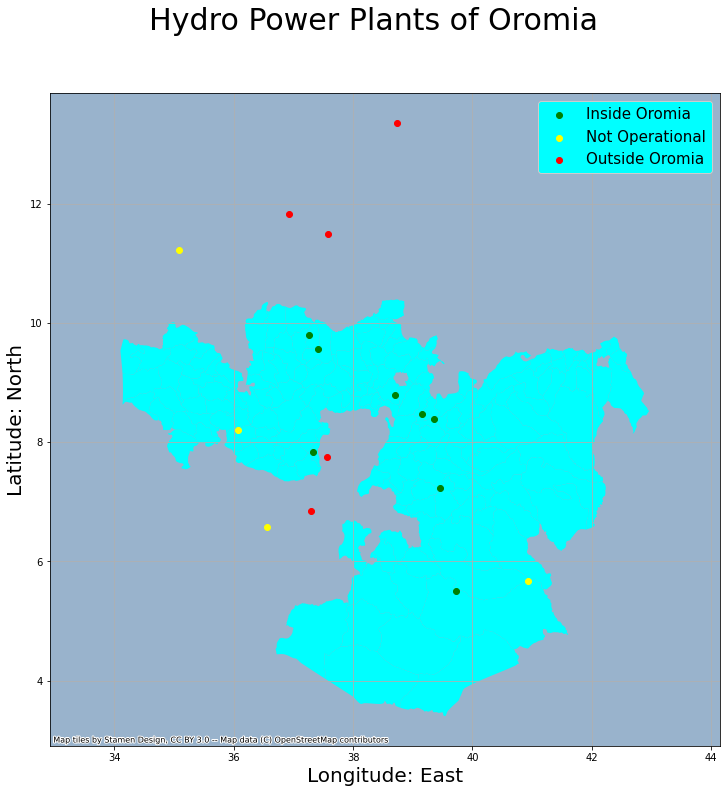

In [5]:
fn.plot_plants(gdf, oromia)

## Can we extract the total power and percentage of Ethiopia’s power in Oromia?...YES

In [6]:
fn.by_the_numbers(gdf)


Ethiopia: Total hydro power production = 4068.0 MWe
Oromia: Total hydro power production = 933.6 MWe
Oromia hydro supports 22.95% of Ethiopian hydro power


### Will any drought-caused power reductions still meet power requirements?

In [7]:
# FILL THIS OUT
drought_index = .2             # 1=total drought/no power production, 0=full power production available) 
ethiopia_min_capacity = 3000.0 # min power required in MWe

fn.drought_power_production(drought_index, ethiopia_min_capacity, gdf)


Success: Drought power production of 3254.4 MWe meets 3000.0 MWe minimum by 8.48%


### Let's say Oromia needs to provide, at a minimum, 15% of Ethiopia's hydro power...what combinations of power plants can support this threshold?

In [8]:
# Get operational plants in Oromia
oromia_hydro = gdf[(gdf['in_oromia'] == True) & (gdf['operational'] == True)]
oromia_hydro = oromia_hydro.reset_index(inplace=False)

In [9]:
#  Enter Data Here
threshold = .15         # percentage of hydro power Oromia must generate for the whole of Ethiopia       
num_op_plants = 4       # choose number of plants available to generate power

In [10]:
# Run to see combinations of plants that will support the required power
total_plants = len(oromia_hydro.index)
ethiopia_max_hydro = 4068.0 
min_power = ethiopia_max_hydro * threshold

fn.combo_it1(total_plants, num_op_plants, min_power,oromia_hydro)

The following plant combination(s) meet the 610.2 MWe requirement:

(['Koka (Awash I)', 'Fincha', 'Gilgel Gibe I', 'Genale Dawa III'], 615.0)
(['Koka (Awash I)', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 634.0)
(['Awash II+III', 'Fincha', 'Gilgel Gibe I', 'Genale Dawa III'], 636.0)
(['Awash II+III', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 655.0)
(['Fincha', 'Fincha Amerti Neshe (FAN)', 'Gilgel Gibe I', 'Genale Dawa III'], 667.0)
(['Fincha', 'Fincha Amerti Neshe (FAN)', 'Melka Wakena', 'Genale Dawa III'], 636.0)
(['Fincha', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 725.0)
(['Fincha Amerti Neshe (FAN)', 'Gilgel Gibe I', 'Melka Wakena', 'Genale Dawa III'], 686.0)
